In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import jax
import jax.numpy as jnp

from typing import Iterable, Generator

from model import Model, ModelHyperparameters, ModelParameters
from model.training import Trainer, TrainingHyperparameters

from model.cortical_column import CorticalColumn, CorticalColumnHyperparameters
from model.synapse import Synapse
from model.hyperparameters import (
    dt,
    cortical_column_hyperparameters,
    sequence_model_hyperparameters,
    semantic_model_hyperparameters,
    training_model_hyperparameters,
    training_hyperparameters,
)

from patterns import collection1_fixed_dimensions, collection1_variable_dimensions

In [4]:
def display(ax, pattern, animated=False):
    ax.imshow(pattern.reshape((20, 20)), cmap="Greys", vmin=0, vmax=1, animated=animated)

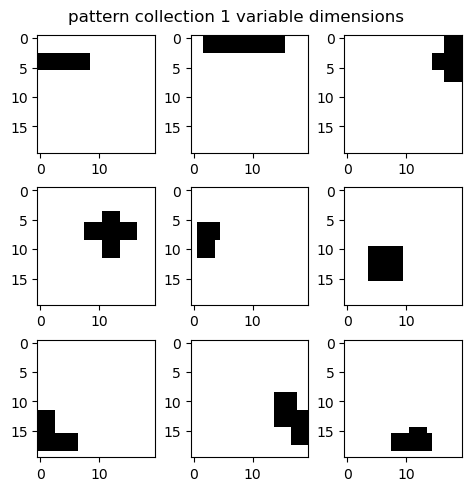

In [5]:
fig, axs = plt.subplots(3, 3, layout="compressed")
for ax, pattern in zip(axs.flat, collection1_variable_dimensions):
    display(ax, pattern)
fig.suptitle("pattern collection 1 variable dimensions")
plt.show()

In [6]:
def corrupt_pattern(key: jax.Array, pattern: jax.Array, fraction: float):
    indices = jnp.flatnonzero(pattern)
    new_indices = jax.random.choice(key, indices, (int(fraction * indices.size),), replace=False)
    new_pattern = jnp.zeros((pattern.size,)).at[new_indices].set(1).reshape(pattern.shape)
    return new_pattern

In [7]:
def train_phase_1(
    key: jax.Array,
    trainer: Trainer,
    model: Model,
    params: ModelParameters,
    collection: jax.Array,
) -> ModelParameters:
    with tqdm(total=len(collection)*2500) as pbar:
        for pattern in collection:
            # initialize state
            state = Model.init_state((400,))
            # excitatory inputs
            excitatory_inputs = 2000 * jnp.array([
                jnp.zeros((400,)),
                pattern,
                pattern,
                pattern,
            ])
            # inhibitory inputs
            inhibitory_inputs = 2000 * jnp.array([
                jnp.zeros((400,)),
                jnp.zeros((400,)),
                pattern,
                pattern,
            ])
            wm_maintenance = jnp.zeros((400,))
            for i in range(2500):
                key, new_key = jax.random.split(key)
                ei, ii = model.add_input_noise(new_key, excitatory_inputs, inhibitory_inputs)
                state, pfr, fifr = model(state, params, ei, ii, wm_maintenance)
                if i > 500:
                    params = trainer.step1(params, pfr, fifr)
                pbar.update(1)
            # fig, axs = plt.subplots(1, 4)
            # for ax, p in zip(axs.flat, pfr):
            #     display(ax, p/5)
            # plt.show()
    params = trainer.normalize(params)
    return params

In [8]:
trainer = Trainer(training_hyperparameters)
training_model = Model(cortical_column_hyperparameters, training_model_hyperparameters, dt)

In [9]:
key = jax.random.key(0)
params = Model.init_params((400,))
params = train_phase_1(key, trainer, training_model, params, collection1_variable_dimensions)

100%|████████████████████████████████████████████████████████| 22500/22500 [00:40<00:00, 555.41it/s]


In [10]:
def simulate_model(
    model: Model,
    params: ModelParameters,
    excitatory_inputs: jax.Array,
    inhibitory_inputs: jax.Array,
    wm_maintenance_signal: jax.Array,
) -> Generator[jax.Array, None, None]:
    state = Model.init_state((400,))
    for ei, ii, wm_maintenance in zip(excitatory_inputs, inhibitory_inputs, wm_maintenance_signal):
        state, pfr, _ = model(state, params, ei, ii, wm_maintenance)
        yield pfr

In [11]:
def input_presentation(pattern: jax.Array, duration: int) -> jax.Array:
    zeros = jnp.zeros((duration, 4, 400))
    # present pattern to layer WM from time 0.005 to 0.055
    excitatory_inputs = 400 * zeros.at[50:550, 0].set(pattern)

    return excitatory_inputs

In [12]:
def generate_wm_maintenance_signal(input_patterns: list[jax.Array], duration: int) -> jax.Array:
    wm_maintenance_signal = jnp.zeros((len(input_patterns) * duration, 400))
    for i, pattern in enumerate(input_patterns):
        # maintenance signal is active from the end of the current input presentation to the start of the next input presentation
        wm_maintenance_signal = wm_maintenance_signal.at[i * duration + 550 : (i + 1) * duration + 50].set(pattern)
    return wm_maintenance_signal

In [13]:
semantic_wm_model = Model(cortical_column_hyperparameters, semantic_model_hyperparameters, dt)
sequence_wm_model = Model(cortical_column_hyperparameters, sequence_model_hyperparameters, dt)

In [14]:
T = 0.4
num_patterns = 2
n = int(T / dt)
key = jax.random.key(1)

key, *keys = jax.random.split(key, num_patterns + 1)
patterns = collection1_variable_dimensions[:num_patterns]
incomplete_patterns = [corrupt_pattern(key, pattern, 0.7) for key, pattern in zip(keys, patterns)]

# present the first num_patterns patterns for T seconds each
excitatory_inputs = jnp.concatenate([input_presentation(pattern, n) for pattern in incomplete_patterns])
# inhibitory inputs are zero
inhibitory_inputs = jnp.zeros_like(excitatory_inputs)
# maintenance signal is zero when our inputs are active, and matches our input when our inputs are inactive
wm_maintenance_signal = excitatory_inputs[:, 0] > 0
wm_maintenance_signal = generate_wm_maintenance_signal(incomplete_patterns, n)
# reset_signal = jnp.concatenate(num_patterns * [jnp.zeros((n,)).at[50].set(1)])
# add noise
excitatory_inputs, inhibitory_inputs = semantic_wm_model.add_input_noise(key, excitatory_inputs, inhibitory_inputs)


t = jnp.arange(0, num_patterns * T, dt)
pfr = jnp.array(list(tqdm(simulate_model(sequence_wm_model, params, excitatory_inputs, inhibitory_inputs, wm_maintenance_signal), total=num_patterns*n)))

100%|█████████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1935.93it/s]


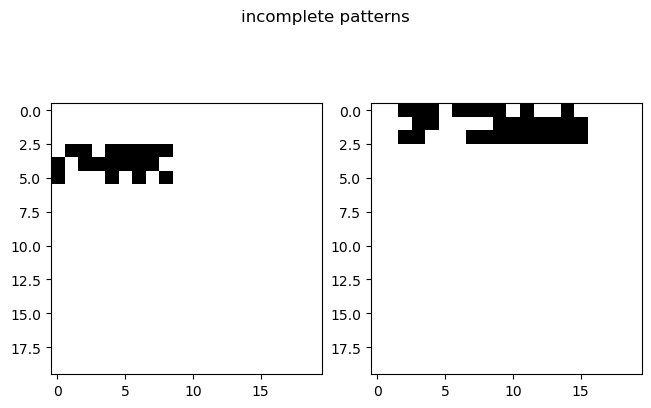

In [15]:
fig, axs = plt.subplots(1, num_patterns, layout="compressed")
for ax, pattern in zip(axs, incomplete_patterns):
    display(ax, pattern)
fig.suptitle("incomplete patterns")
plt.show()

Text(0, 0.5, 'firing rate (Hz)')

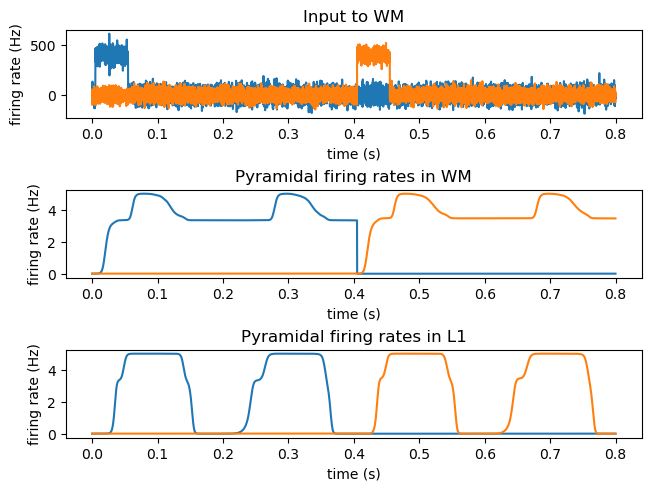

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, layout="compressed")
for pattern, incomplete_pattern in zip(patterns, incomplete_patterns):
    ax1.plot(t, jnp.sum(excitatory_inputs[:, 0] * incomplete_pattern, axis=1) / jnp.sum(incomplete_pattern))
    ax2.plot(t, jnp.sum(pfr[:, 0] * pattern, axis=1) / jnp.sum(pattern))
    ax3.plot(t, jnp.sum(pfr[:, 1] * pattern, axis=1) / jnp.sum(pattern))

ax1.set_title("Input to WM")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("firing rate (Hz)")

ax2.set_title("Pyramidal firing rates in WM")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("firing rate (Hz)")

ax3.set_title("Pyramidal firing rates in L1")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("firing rate (Hz)")